In [3]:
import torch
torch.__version__
import torch_directml


In [4]:
torch.__version__
device = torch_directml.device()
print(device) 
# print(torch.cuda.is_available()) 

privateuseone:0


In [5]:
from pathlib import Path
import random
import glob
from PIL import Image

random.seed(42)

# Path.absolute
all_images = glob.glob("*/*/*.jpg")
random_path = random.choice(all_images)
image_class = Path(random_path).parent.stem
img = Image.open(random_path)

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 

from matplotlib import style
style.use("ggplot")

[[[248 131  62]
  [254 137  68]
  [249 134  67]
  ...
  [225 130  84]
  [230 135  89]
  [236 141  95]]

 [[249 130  62]
  [253 136  67]
  [250 133  66]
  ...
  [225 130  84]
  [230 135  89]
  [235 140  94]]

 [[250 128  61]
  [253 134  66]
  [249 130  64]
  ...
  [226 131  85]
  [230 135  89]
  [235 140  94]]

 ...

 [[236 236 248]
  [232 232 242]
  [233 233 243]
  ...
  [167 168 196]
  [164 164 190]
  [165 163 187]]

 [[236 236 248]
  [232 232 244]
  [233 233 243]
  ...
  [168 168 196]
  [168 166 190]
  [168 162 188]]

 [[235 235 247]
  [232 232 244]
  [233 233 243]
  ...
  [170 170 198]
  [169 167 191]
  [170 164 190]]]


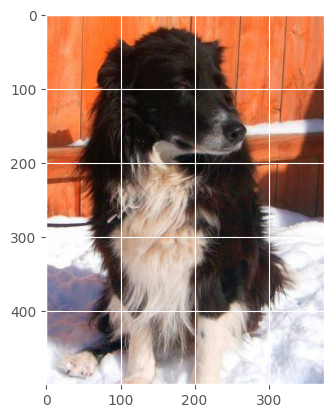

In [7]:
img_as_array = np.asarray(img)
plt.imshow(img_as_array)

print(img_as_array)

In [8]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

IMG_SIZE = (128, 128)

data_transform = transforms.Compose([
    transforms.Resize(size=IMG_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

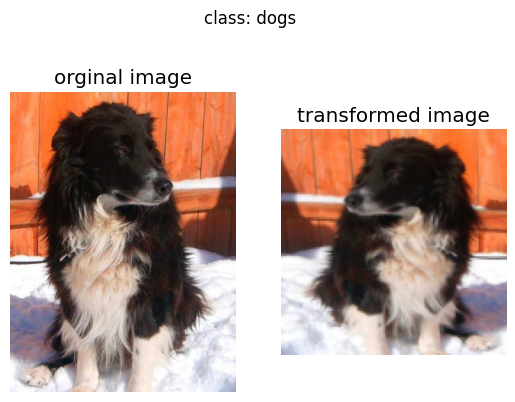

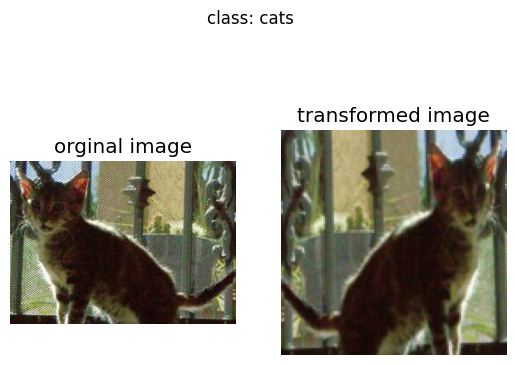

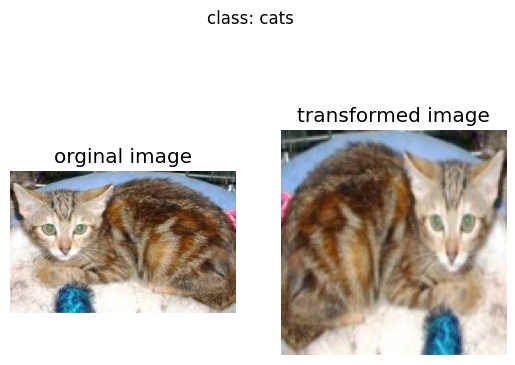

In [9]:
def plot_transformed_images(images_path, transformer, seed=42, n=5):
    random.seed(seed)
    random_images_path = random.sample(images_path, k=n)
    for random_image in random_images_path:
        fig, ax = plt.subplots(1, 2)
        image = Image.open(random_image)
        image_as_array = np.asarray(image)
        cls = Path(random_image).parent.stem
        ax[0].imshow(image_as_array)
        ax[0].axis("off")
        ax[0].set_title("orginal image")

        transformed_image = transformer(image).permute(1, 2, 0)
        ax[1].imshow(transformed_image)
        ax[1].axis("off")
        ax[1].set_title("transformed image")

        fig.suptitle(f"class: {cls}")

plot_transformed_images(images_path=all_images, transformer=data_transform, n=3)

In [10]:
train_data = datasets.ImageFolder(root="training_set/", transform=data_transform, target_transform=None)
test_data = datasets.ImageFolder(root="test_set/", transform=data_transform)

classes = train_data.classes

print(train_data, test_data)

Dataset ImageFolder
    Number of datapoints: 8005
    Root location: training_set/
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           ) Dataset ImageFolder
    Number of datapoints: 2023
    Root location: test_set/
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


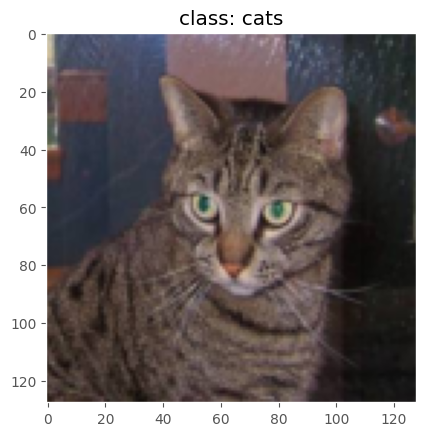

In [11]:
img, label = train_data[0][0], train_data[0][1]
img = img.permute(1, 2, 0)

plt.imshow(img)
plt.grid(0)
plt.title(f"class: {classes[label]}")
plt.show()

In [12]:
import os
NUM_WORKERS = os.cpu_count() // 2

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=1,
    num_workers=NUM_WORKERS,
    shuffle=True
)

test_data = DataLoader(
    dataset=test_data,
    batch_size=1,
    num_workers=NUM_WORKERS,
    shuffle=False
)

train_data 

Dataset ImageFolder
    Number of datapoints: 8005
    Root location: training_set/
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [13]:
IMAGE_SIZE = (224, 224)

train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()
])

train_data_agt = datasets.ImageFolder(root='training_set/', transform=train_transform, target_transform=None)
test_data_agt = datasets.ImageFolder(root='test_set/', transform=train_transform, target_transform=None)


In [14]:
BATCH_SIZE = 8
torch.manual_seed(42)

train_dataloader_agt = DataLoader(dataset=train_data_agt, batch_size=BATCH_SIZE, num_workers=0, shuffle=True)
test_dataloader_agt = DataLoader(dataset=test_data_agt, batch_size=BATCH_SIZE, num_workers=0, shuffle=False)


iter(train_dataloader_agt)

In [15]:
class ImageClassifier(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer_1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2)
        )
        self.layer_2 = nn.Sequential(
            nn.Conv2d(64, 512, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2)
        )
        self.layer_3 = nn.Sequential(
            nn.Conv2d(512, 512, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2)
        )

        with torch.no_grad():
            dummy = torch.randn(1, *(3, 224, 224))
            featues = self.layer_3(self.layer_2(self.layer_1(dummy)))
            self.flatten_size = featues.numel()
            print(self.flatten_size)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=self.flatten_size, out_features=2)
        )
    def forward(self, x: torch.Tensor):
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.classifier(x)
        return x
    
model = ImageClassifier().to(device)

401408


In [16]:
img_batch, label_batch = next(iter(train_dataloader_agt))
img, label = img_batch[0].unsqueeze(dim=0), label_batch[0]

model.eval()
with torch.no_grad():
    pred = model(img.to(device))


In [17]:
import torchinfo

torchinfo.summary(model, input_size=[1,3,224,224])

Layer (type:depth-idx)                   Output Shape              Param #
ImageClassifier                          [1, 2]                    --
├─Sequential: 1-1                        [1, 64, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─BatchNorm2d: 2-3                  [1, 64, 224, 224]         128
│    └─MaxPool2d: 2-4                    [1, 64, 112, 112]         --
├─Sequential: 1-2                        [1, 512, 56, 56]          --
│    └─Conv2d: 2-5                       [1, 512, 112, 112]        295,424
│    └─ReLU: 2-6                         [1, 512, 112, 112]        --
│    └─BatchNorm2d: 2-7                  [1, 512, 112, 112]        1,024
│    └─MaxPool2d: 2-8                    [1, 512, 56, 56]          --
├─Sequential: 1-3                        [1, 512, 28, 28]          --
│    └─Conv2d: 2-9                       [1, 512, 56, 56]          2,359,

In [18]:
import torch.utils.data.dataloader


def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    
    model.train()

    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):

        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)
    
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

In [19]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            
            X, y = X.to(device), y.to(device)


            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss   

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc


In [23]:
from tqdm.auto import tqdm


def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int = 5):
    
    results = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }

    for epoch in tqdm(range(epochs)):

        # torch_directml.clear_cache()
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn)
        

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    
    return results

In [21]:
# torch.manual_seed(42)
# torch.set_default_dtype(torch.float32)
# torch.backends.cudnn.benchmark = True

# NUM_EPOCHS = 5

# loss_fn = nn.CrossEntropyLoss().to(device)
# optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

# from timeit import default_timer as timer 

# st = timer()

# model_results = train(model=model,
#                       train_dataloader=train_dataloader_agt,
#                       test_dataloader=test_dataloader_agt,
#                       optimizer=optimizer,
#                       loss_fn=loss_fn,
#                       epochs=NUM_EPOCHS)

# end = timer()

# print(end - st)

In [ ]:
import torch
import torch_directml
import torch.nn as nn

torch.manual_seed(42)

model = model.to(device)

loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

for batch in train_dataloader_agt:
    img_batch, label_batch = batch
    img_batch = img_batch.to(device)
    label_batch = label_batch.to(device)
    break 

NUM_EPOCHS = 5

from timeit import default_timer as timer

st = timer()

model_results = train(model=model,
                      train_dataloader=train_dataloader_agt,
                      test_dataloader=test_dataloader_agt,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS)

end = timer()

print(f"Training time: {end - st:.2f} sec")


  0%|          | 0/5 [00:00<?, ?it/s]C:\Users\xin\AppData\Roaming\Python\Python312\site-packages\torch\optim\adam.py:534: UserWarning: The operator 'aten::lerp.Scalar_out' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at C:\__w\1\s\pytorch-directml-plugin\torch_directml\csrc\dml\dml_cpu_fallback.cpp:17.)
  torch._foreach_lerp_(device_exp_avgs, device_grads, 1 - beta1)
 20%|██        | 1/5 [27:08<1:48:35, 1628.89s/it]

Epoch: 1 | train_loss: 57.8675 | train_acc: 0.5405 | test_loss: 51.6366 | test_acc: 0.5527


 40%|████      | 2/5 [51:36<1:16:42, 1534.16s/it]

Epoch: 2 | train_loss: 28.3277 | train_acc: 0.5765 | test_loss: 17.6825 | test_acc: 0.5535


 60%|██████    | 3/5 [1:18:29<52:20, 1570.01s/it]

Epoch: 3 | train_loss: 10.6424 | train_acc: 0.6075 | test_loss: 6.1967 | test_acc: 0.5819


 80%|████████  | 4/5 [1:44:29<26:06, 1566.03s/it]

Epoch: 4 | train_loss: 3.3453 | train_acc: 0.6307 | test_loss: 1.9634 | test_acc: 0.6249


100%|██████████| 5/5 [2:10:25<00:00, 1565.03s/it]

Epoch: 5 | train_loss: 0.9916 | train_acc: 0.6661 | test_loss: 0.7878 | test_acc: 0.6500
Training time: 7825.17 sec
